# License Plate Dataset Validation - DataV2

This notebook loads and validates the license plate detection dataset from DataV2:
- Dataset structure: Located in `c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV2`
  - `annotations/` folder: Contains XML files with bounding box coordinates
  - `images/` folder: Contains PNG image files of vehicles

We'll:
1. Load the annotations and images
2. Parse the XML annotation files
3. Visualize the bounding boxes on their images to validate the annotations
4. Perform a quality check of the annotations

In [2]:
# Import required libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import xml.etree.ElementTree as ET  # For parsing XML annotation files
from tqdm import tqdm
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)

## 1. Load the Dataset

First, we'll set up the paths to the DataV2 dataset, which is organized into two folders:
- `annotations/`: XML files containing bounding box coordinates
- `images/`: PNG files of vehicles with license plates

In [3]:
# Set up paths to the dataset
base_dir = os.path.abspath(r"c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV2")
annotations_dir = os.path.join(base_dir, "annotations")
images_dir = os.path.join(base_dir, "images")

# Verify the dataset exists
if os.path.exists(base_dir):
    print(f"✓ Dataset found at {base_dir}")
    
    # Check annotations directory
    if os.path.exists(annotations_dir):
        print(f"✓ Annotations directory found at {annotations_dir}")
        xml_files = [f for f in os.listdir(annotations_dir) if f.lower().endswith('.xml')]
        print(f"✓ Found {len(xml_files)} XML annotation files")
    else:
        print(f"✗ Annotations directory not found at {annotations_dir}")
    
    # Check images directory
    if os.path.exists(images_dir):
        print(f"✓ Images directory found at {images_dir}")
        image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"✓ Found {len(image_files)} image files")
    else:
        print(f"✗ Images directory not found at {images_dir}")
        
else:
    print(f"✗ Dataset not found at {base_dir}")

✓ Dataset found at c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV2
✓ Annotations directory found at c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV2\annotations
✓ Found 433 XML annotation files
✓ Images directory found at c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV2\images
✓ Found 433 image files


## 2. Parse XML Annotations

Let's create a function to parse the XML annotation files and extract the bounding box coordinates.

In [4]:
def parse_xml_annotation(xml_file):
    """
    Parse XML annotation file and extract relevant information
    
    Args:
        xml_file (str): Path to the XML file
        
    Returns:
        dict: Dictionary containing the parsed information
    """
    try:
        # Parse XML file
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Get filename
        filename = root.find('filename').text
        
        # Get path if available
        path_elem = root.find('path')
        path = path_elem.text if path_elem is not None else ''
        
        # Get size information
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        depth = int(size.find('depth').text) if size.find('depth') is not None else 3
        
        # Get object information
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            
            # Get bounding box
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            
            # Get other attributes if available
            pose_elem = obj.find('pose')
            pose = pose_elem.text if pose_elem is not None else 'Unspecified'
            
            truncated_elem = obj.find('truncated')
            truncated = int(truncated_elem.text) if truncated_elem is not None else 0
            
            difficult_elem = obj.find('difficult')
            difficult = int(difficult_elem.text) if difficult_elem is not None else 0
            
            # Add to list of objects
            objects.append({
                'name': name,
                'pose': pose,
                'truncated': truncated,
                'difficult': difficult,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax
            })
        
        return {
            'filename': filename,
            'path': path,
            'width': width,
            'height': height,
            'depth': depth,
            'objects': objects
        }
    except Exception as e:
        print(f"Error parsing XML file {xml_file}: {e}")
        return None

## 3. Load All Annotations

Now, let's load all the XML annotations and create a DataFrame to make the data easier to work with.

In [5]:
def load_all_annotations(annotations_dir):
    """
    Load all XML annotations from a directory
    
    Args:
        annotations_dir (str): Directory containing XML annotation files
        
    Returns:
        DataFrame: DataFrame containing all annotations
    """
    print(f"Loading XML annotations from {annotations_dir}...")
    
    annotations = []
    xml_files = [os.path.join(annotations_dir, f) for f in os.listdir(annotations_dir) 
                if f.lower().endswith('.xml')]
    
    print(f"Found {len(xml_files)} XML files")
    
    for xml_file in tqdm(xml_files, desc="Parsing XML files"):
        annotation = parse_xml_annotation(xml_file)
        if annotation:
            base_filename = os.path.splitext(os.path.basename(xml_file))[0]
            for obj in annotation['objects']:
                annotations.append({
                    'file': base_filename,
                    'filename': annotation['filename'],
                    'width': annotation['width'],
                    'height': annotation['height'],
                    'class': obj['name'],
                    'pose': obj['pose'],
                    'truncated': obj['truncated'],
                    'difficult': obj['difficult'],
                    'xmin': obj['xmin'],
                    'ymin': obj['ymin'],
                    'xmax': obj['xmax'],
                    'ymax': obj['ymax']
                })
    
    # Convert to DataFrame
    if annotations:
        annotations_df = pd.DataFrame(annotations)
        
        # Print basic statistics
        print("\nAnnotation dataframe structure:")
        print(annotations_df.head())
        
        print("\nColumns:", annotations_df.columns.tolist())
        
        print("\nDataset statistics:")
        print(f"Number of annotations: {len(annotations_df)}")
        print(f"Number of unique images: {annotations_df['file'].nunique()}")
        
        # Count classes
        class_counts = annotations_df['class'].value_counts()
        print("\nClass distribution:")
        for class_name, count in class_counts.items():
            print(f"  {class_name}: {count}")
            
        return annotations_df
    else:
        print("No annotations found or could be parsed")
        return None

# Load all annotations
if os.path.exists(annotations_dir):
    annotations_df = load_all_annotations(annotations_dir)
else:
    print(f"Error: Annotations directory {annotations_dir} does not exist")
    annotations_df = None

Loading XML annotations from c:\ULB\MA1\Proj\PROJ-H419\Car-plate-detection\DataV2\annotations...
Found 433 XML files


Parsing XML files: 100%|██████████| 433/433 [00:04<00:00, 103.19it/s]


Annotation dataframe structure:
      file     filename  width  height    class         pose  truncated  \
0    Cars0    Cars0.png    500     268  licence  Unspecified          0   
1    Cars1    Cars1.png    400     248  licence  Unspecified          0   
2   Cars10   Cars10.png    400     225  licence  Unspecified          0   
3  Cars100  Cars100.png    400     267  licence  Unspecified          0   
4  Cars101  Cars101.png    400     300  licence  Unspecified          0   

   difficult  xmin  ymin  xmax  ymax  
0          0   226   125   419   173  
1          0   134   128   262   160  
2          0   140     5   303   148  
3          0   175   114   214   131  
4          0   167   202   240   220  

Columns: ['file', 'filename', 'width', 'height', 'class', 'pose', 'truncated', 'difficult', 'xmin', 'ymin', 'xmax', 'ymax']

Dataset statistics:
Number of annotations: 471
Number of unique images: 433

Class distribution:
  licence: 471


## 4. Check Image-Annotation Matches

Let's check if all annotations have corresponding images and vice versa.

In [6]:
def check_image_annotation_matches(annotations_df, images_dir):
    """
    Check if all annotations have corresponding images and vice versa
    
    Args:
        annotations_df (DataFrame): DataFrame containing annotations
        images_dir (str): Directory containing image files
        
    Returns:
        tuple: Lists of matched pairs, missing images, and missing annotations
    """
    if annotations_df is None:
        print("No annotations to check")
        return [], [], []
    
    # Get unique image filenames from annotations
    annotation_files = annotations_df['file'].unique()
    print(f"Number of unique annotation files: {len(annotation_files)}")
    
    # Get image filenames from directory
    image_files = [os.path.splitext(f)[0] for f in os.listdir(images_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Number of image files: {len(image_files)}")
    
    # Find matches and mismatches
    matched_pairs = set(annotation_files).intersection(set(image_files))
    missing_images = set(annotation_files) - set(image_files)
    missing_annotations = set(image_files) - set(annotation_files)
    
    print(f"\nMatched pairs: {len(matched_pairs)}")
    print(f"Annotations without images: {len(missing_images)}")
    if missing_images:
        print("  First few examples:", list(missing_images)[:5])
    
    print(f"Images without annotations: {len(missing_annotations)}")
    if missing_annotations:
        print("  First few examples:", list(missing_annotations)[:5])
    
    return list(matched_pairs), list(missing_images), list(missing_annotations)

# Check matches
if annotations_df is not None and os.path.exists(images_dir):
    matched_pairs, missing_images, missing_annotations = check_image_annotation_matches(
        annotations_df, images_dir)

Number of unique annotation files: 433
Number of image files: 433

Matched pairs: 433
Annotations without images: 0
Images without annotations: 0


## 5. Visualization Functions

Let's create functions to visualize images with their bounding boxes.

In [7]:
def visualize_image_with_boxes(image_basename, annotations_df, images_dir, figsize=(10, 8)):
    """
    Visualize an image with its bounding boxes
    
    Args:
        image_basename (str): Base filename (without extension)
        annotations_df (DataFrame): DataFrame containing annotations
        images_dir (str): Directory containing image files
        figsize (tuple): Figure size (width, height)
    """
    # Get annotations for this image
    image_annotations = annotations_df[annotations_df['file'] == image_basename]
    
    if len(image_annotations) == 0:
        print(f"No annotations found for {image_basename}")
        return
    
    # Try to find the image file (with various possible extensions)
    img_path = None
    for ext in ['.png', '.jpg', '.jpeg']:
        possible_path = os.path.join(images_dir, image_basename + ext)
        if os.path.exists(possible_path):
            img_path = possible_path
            break
    
    if img_path is None:
        print(f"Image file not found for {image_basename}")
        return
    
    # Read the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image at {img_path}")
        return
    
    # Convert from BGR to RGB (OpenCV loads as BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img)
    
    # Draw bounding boxes
    for _, anno in image_annotations.iterrows():
        xmin = anno['xmin']
        ymin = anno['ymin']
        width = anno['xmax'] - xmin
        height = anno['ymax'] - ymin
        
        # Create rectangle
        rect = plt.Rectangle((xmin, ymin), width, height,
                            fill=False, edgecolor='lime', linewidth=2)
        ax.add_patch(rect)
        
        # Add label
        ax.text(xmin, ymin-10, anno['class'],
                color='white', fontsize=12, 
                bbox=dict(facecolor='green', alpha=0.7, pad=2))
    
    # Set title and turn off axis
    ax.set_title(f"Image: {os.path.basename(img_path)}")
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_random_samples(annotations_df, images_dir, n=5):
    """
    Visualize random sample images with their bounding boxes
    
    Args:
        annotations_df (DataFrame): DataFrame containing annotations
        images_dir (str): Directory containing image files
        n (int): Number of random samples to visualize
    """
    if annotations_df is None or len(annotations_df) == 0:
        print("No annotations available for visualization")
        return
    
    # Get unique image files
    unique_files = annotations_df['file'].unique()
    
    # Sample random images
    sampled_files = random.sample(list(unique_files), min(n, len(unique_files)))
    
    # Visualize each sampled image
    for image_basename in sampled_files:
        visualize_image_with_boxes(image_basename, annotations_df, images_dir)

## 6. Visualize Random Samples

Let's visualize some random samples to check if the bounding boxes correctly align with the license plates.


Visualizing random samples with bounding boxes:


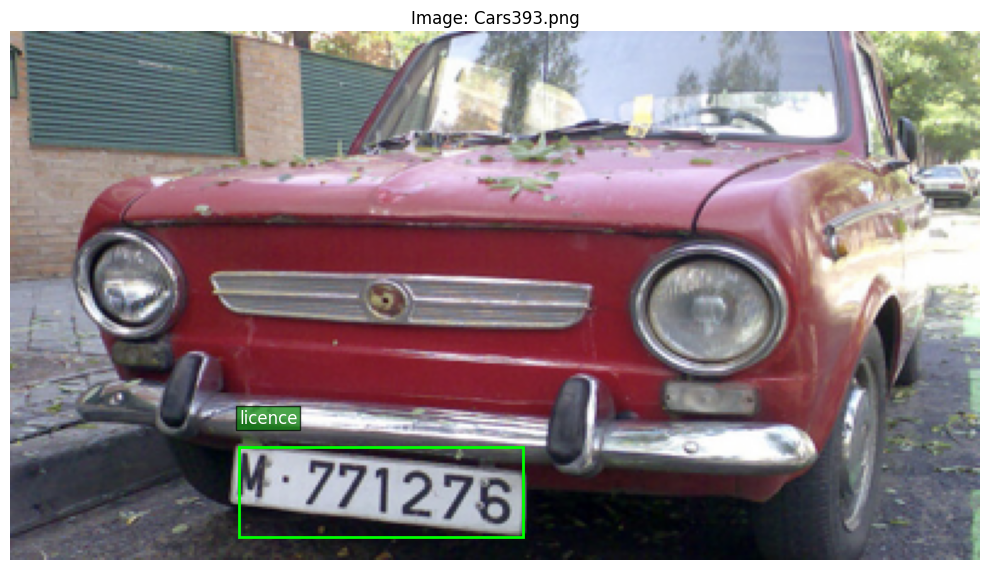

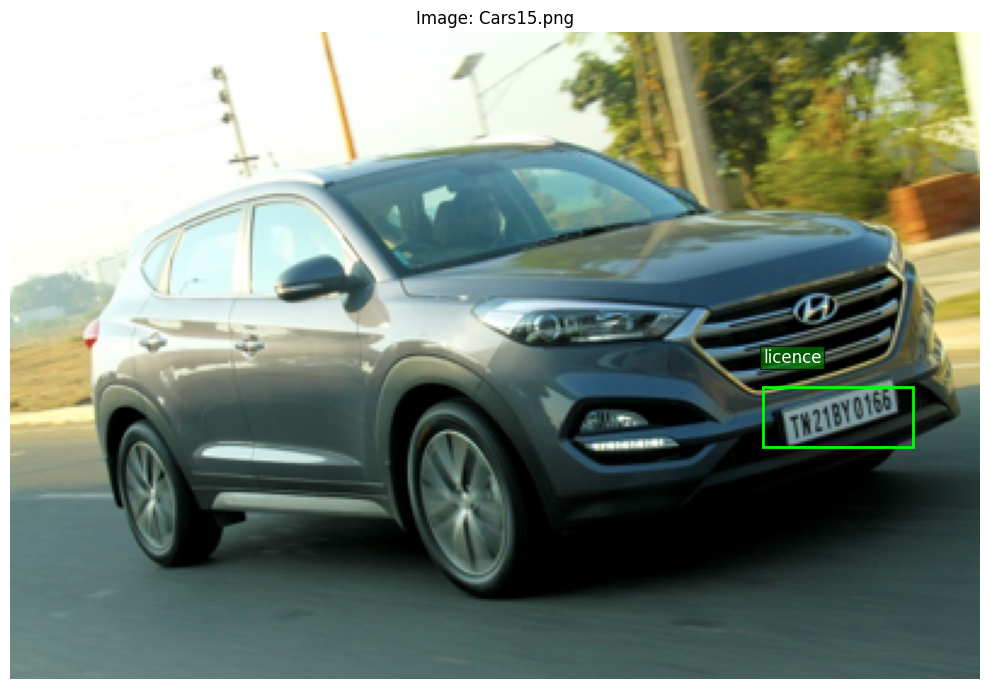

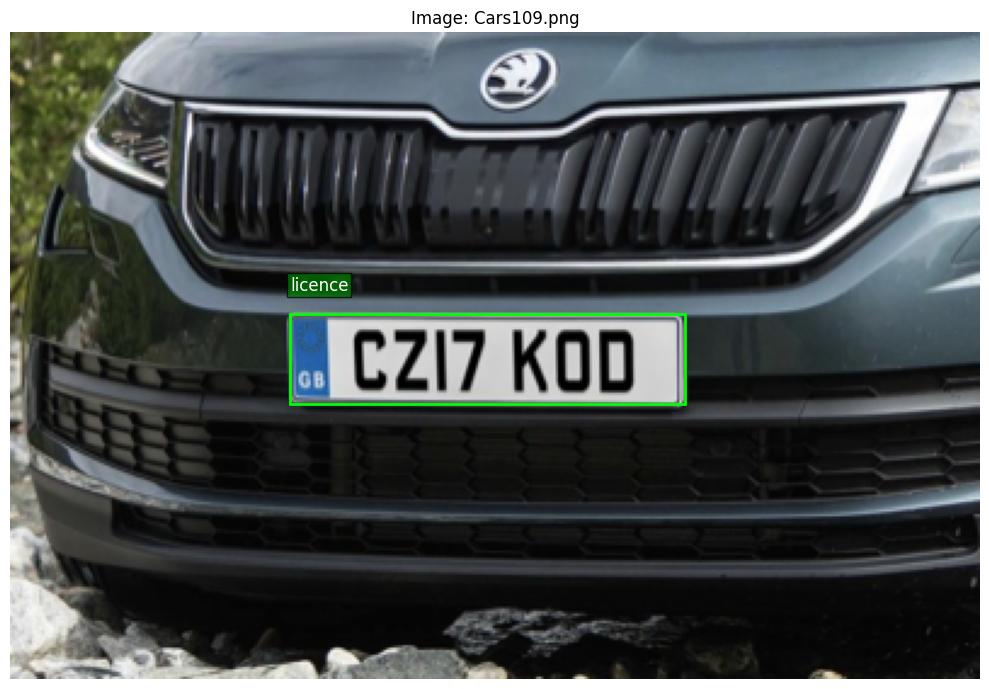

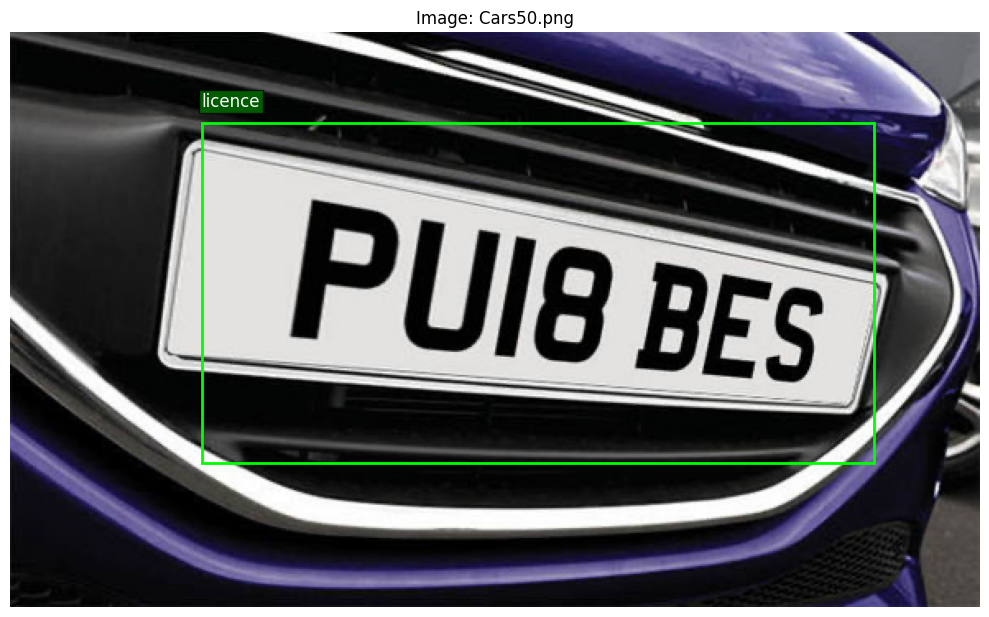

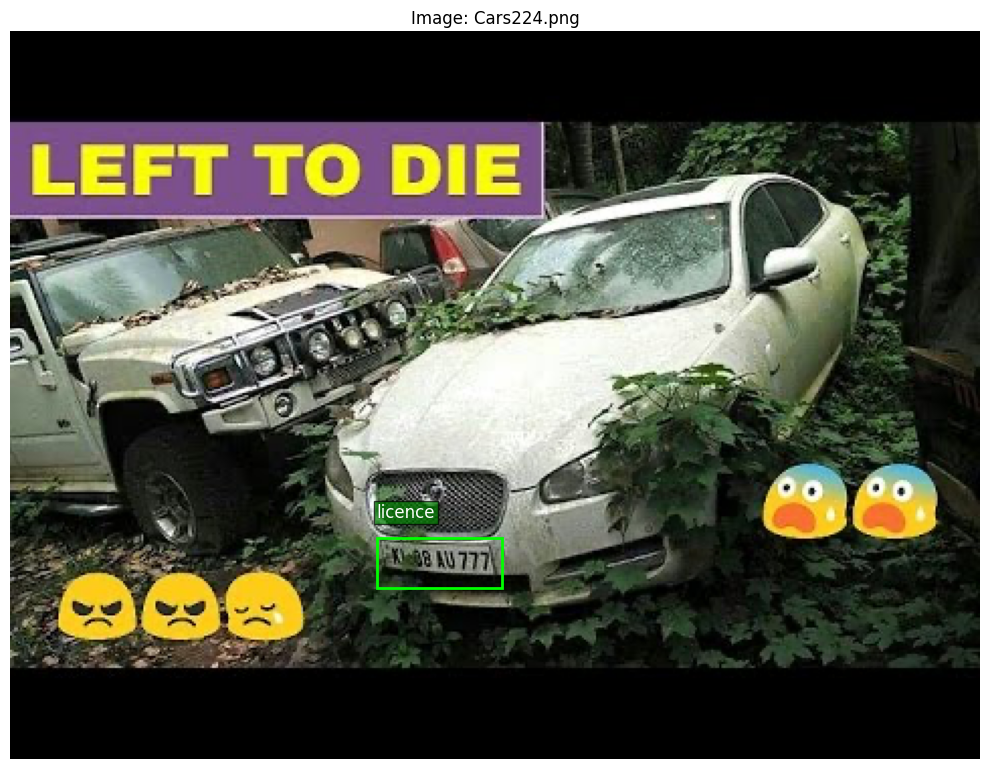

In [8]:
# Visualize random samples
if annotations_df is not None and os.path.exists(images_dir):
    print("\nVisualizing random samples with bounding boxes:")
    visualize_random_samples(annotations_df, images_dir, n=5)

## 7. Annotation Quality Check

Let's check the quality of annotations by:
1. Checking for unusually small or large bounding boxes
2. Analyzing the position of boxes (should be in reasonable parts of the image)
3. Looking for outliers in bounding box dimensions


Bounding Box Statistics:
Average box width: 97.79 pixels
Average box height: 35.18 pixels
Average box area: 5245.98 square pixels
Average box aspect ratio: 2.96 (width/height)

Relative Box Size Statistics (percentage of image):
Average relative width: 22.84%
Average relative height: 12.28%
Average relative area: 4.05%

Potential Issues:
Found 4 unusually small boxes (< 0.1% of image area)
  Example files: ['Cars103', 'Cars188', 'Cars277']
Found 3 unusually large boxes (> 50% of image area)
  Example files: ['Cars114', 'Cars131', 'Cars211']
Found 30 boxes very close to image edges
  Example files: ['Cars10', 'Cars114', 'Cars124']


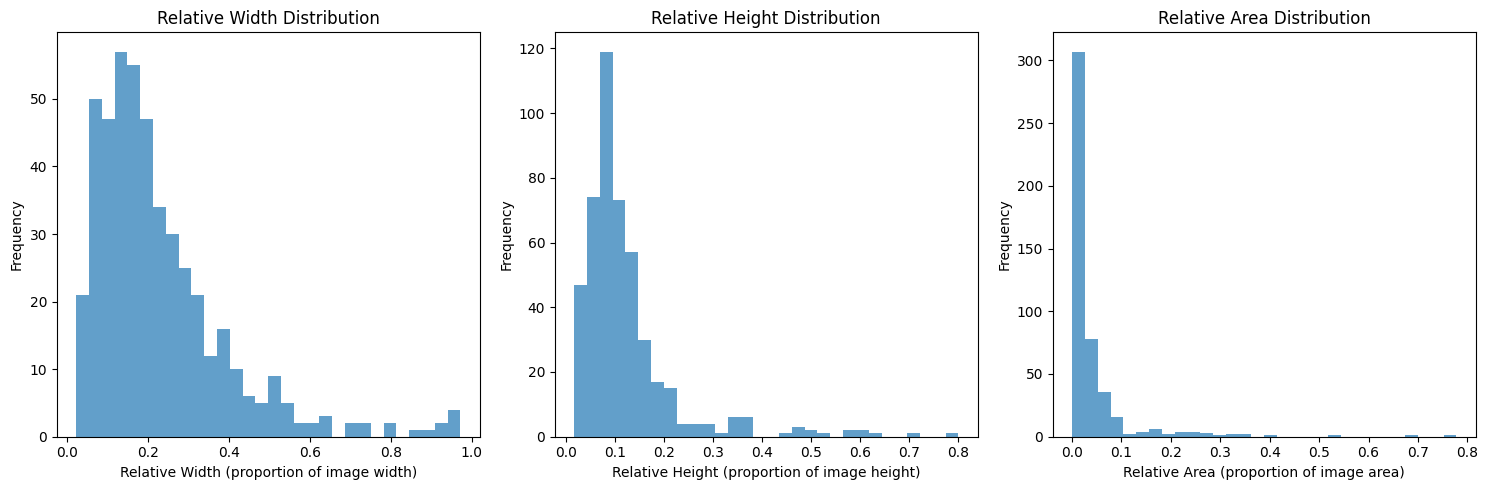

In [9]:
def analyze_annotation_quality(annotations_df):
    """
    Analyze the quality of annotations
    
    Args:
        annotations_df (DataFrame): DataFrame containing annotations
    """
    if annotations_df is None or len(annotations_df) == 0:
        print("No annotations available for analysis")
        return
    
    # Add calculated fields
    annotations_df['box_width'] = annotations_df['xmax'] - annotations_df['xmin']
    annotations_df['box_height'] = annotations_df['ymax'] - annotations_df['ymin']
    annotations_df['box_area'] = annotations_df['box_width'] * annotations_df['box_height']
    annotations_df['box_aspect_ratio'] = annotations_df['box_width'] / annotations_df['box_height']
    annotations_df['rel_width'] = annotations_df['box_width'] / annotations_df['width']
    annotations_df['rel_height'] = annotations_df['box_height'] / annotations_df['height']
    annotations_df['rel_area'] = annotations_df['box_area'] / (annotations_df['width'] * annotations_df['height'])
    
    # Calculate statistics
    print("\nBounding Box Statistics:")
    print(f"Average box width: {annotations_df['box_width'].mean():.2f} pixels")
    print(f"Average box height: {annotations_df['box_height'].mean():.2f} pixels")
    print(f"Average box area: {annotations_df['box_area'].mean():.2f} square pixels")
    print(f"Average box aspect ratio: {annotations_df['box_aspect_ratio'].mean():.2f} (width/height)")
    
    print("\nRelative Box Size Statistics (percentage of image):")
    print(f"Average relative width: {100 * annotations_df['rel_width'].mean():.2f}%")
    print(f"Average relative height: {100 * annotations_df['rel_height'].mean():.2f}%")
    print(f"Average relative area: {100 * annotations_df['rel_area'].mean():.2f}%")
    
    # Check for potentially problematic annotations
    print("\nPotential Issues:")
    
    # Too small boxes
    small_boxes = annotations_df[annotations_df['rel_area'] < 0.001]  # Less than 0.1% of image
    if len(small_boxes) > 0:
        print(f"Found {len(small_boxes)} unusually small boxes (< 0.1% of image area)")
        print("  Example files:", small_boxes['file'].unique()[:3].tolist())
    
    # Too large boxes
    large_boxes = annotations_df[annotations_df['rel_area'] > 0.5]  # More than 50% of image
    if len(large_boxes) > 0:
        print(f"Found {len(large_boxes)} unusually large boxes (> 50% of image area)")
        print("  Example files:", large_boxes['file'].unique()[:3].tolist())
    
    # Extreme aspect ratios
    extreme_ar = annotations_df[(annotations_df['box_aspect_ratio'] > 10) | 
                                (annotations_df['box_aspect_ratio'] < 0.1)]
    if len(extreme_ar) > 0:
        print(f"Found {len(extreme_ar)} boxes with extreme aspect ratios (> 10:1 or < 1:10)")
        print("  Example files:", extreme_ar['file'].unique()[:3].tolist())
    
    # Boxes near image edge
    edge_margin = 0.03  # 3% of image dimension
    edge_boxes = annotations_df[
        (annotations_df['xmin'] < annotations_df['width'] * edge_margin) |
        (annotations_df['ymin'] < annotations_df['height'] * edge_margin) |
        (annotations_df['xmax'] > annotations_df['width'] * (1 - edge_margin)) |
        (annotations_df['ymax'] > annotations_df['height'] * (1 - edge_margin))
    ]
    if len(edge_boxes) > 0:
        print(f"Found {len(edge_boxes)} boxes very close to image edges")
        print("  Example files:", edge_boxes['file'].unique()[:3].tolist())
    
    # Plot histograms of relative sizes
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(annotations_df['rel_width'], bins=30, alpha=0.7)
    plt.title('Relative Width Distribution')
    plt.xlabel('Relative Width (proportion of image width)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(annotations_df['rel_height'], bins=30, alpha=0.7)
    plt.title('Relative Height Distribution')
    plt.xlabel('Relative Height (proportion of image height)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(annotations_df['rel_area'], bins=30, alpha=0.7)
    plt.title('Relative Area Distribution')
    plt.xlabel('Relative Area (proportion of image area)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Return problematic cases for further inspection
    return {
        'small_boxes': small_boxes,
        'large_boxes': large_boxes,
        'extreme_aspect_ratio': extreme_ar,
        'edge_boxes': edge_boxes
    }

# Analyze annotation quality
if annotations_df is not None:
    problematic_cases = analyze_annotation_quality(annotations_df)

## 8. Visualize Potentially Problematic Cases

If any potentially problematic annotations were identified, let's visualize some examples to check if they're actually issues or legitimate annotations.


Unusually Small Boxes:
Visualizing Cars188 (problematic: Unusually Small Boxes)


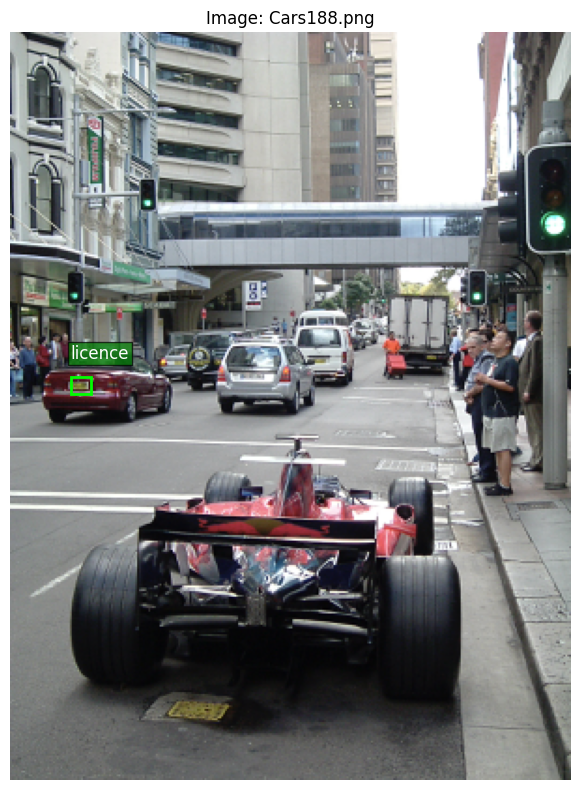

Visualizing Cars103 (problematic: Unusually Small Boxes)


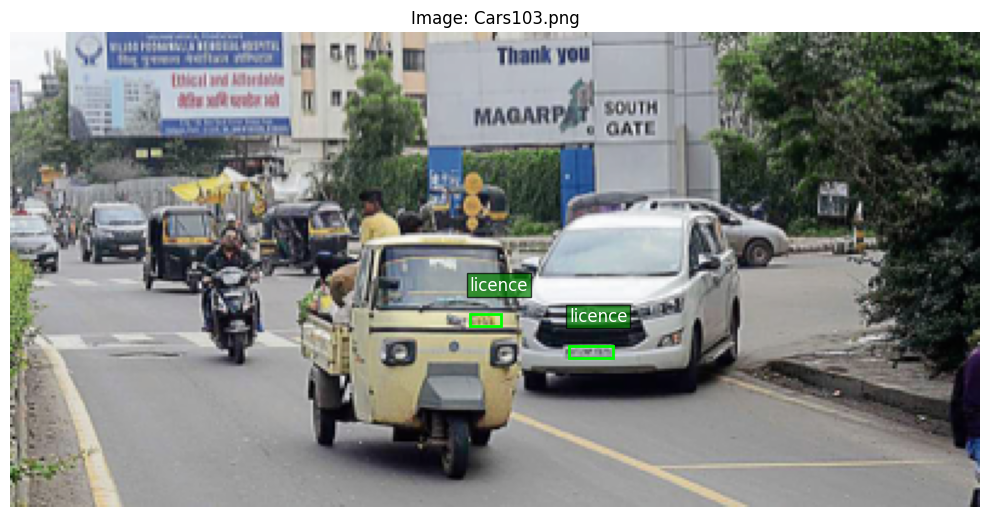


Unusually Large Boxes:
Visualizing Cars114 (problematic: Unusually Large Boxes)


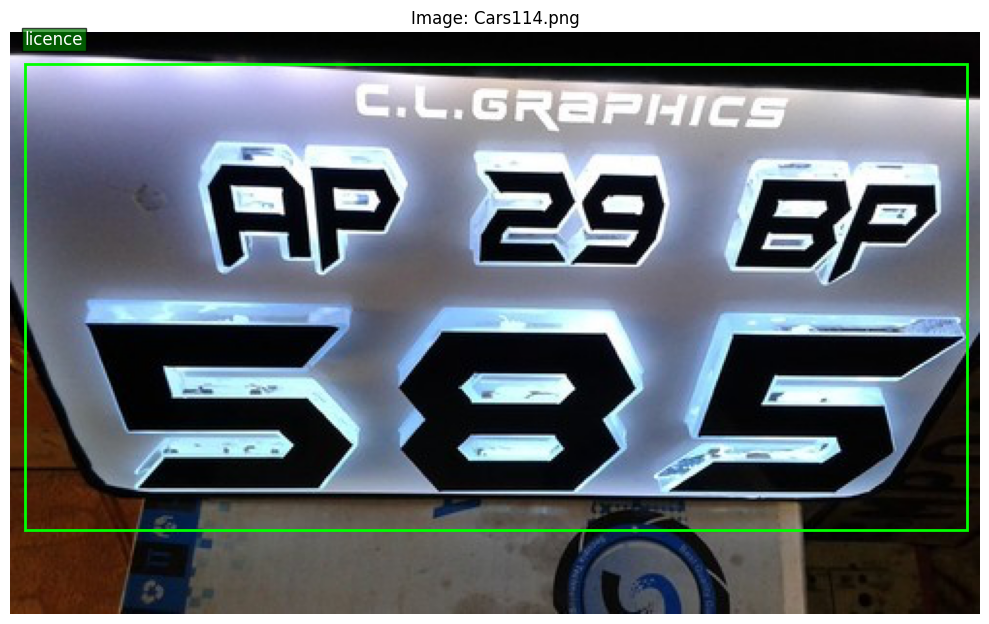

Visualizing Cars211 (problematic: Unusually Large Boxes)


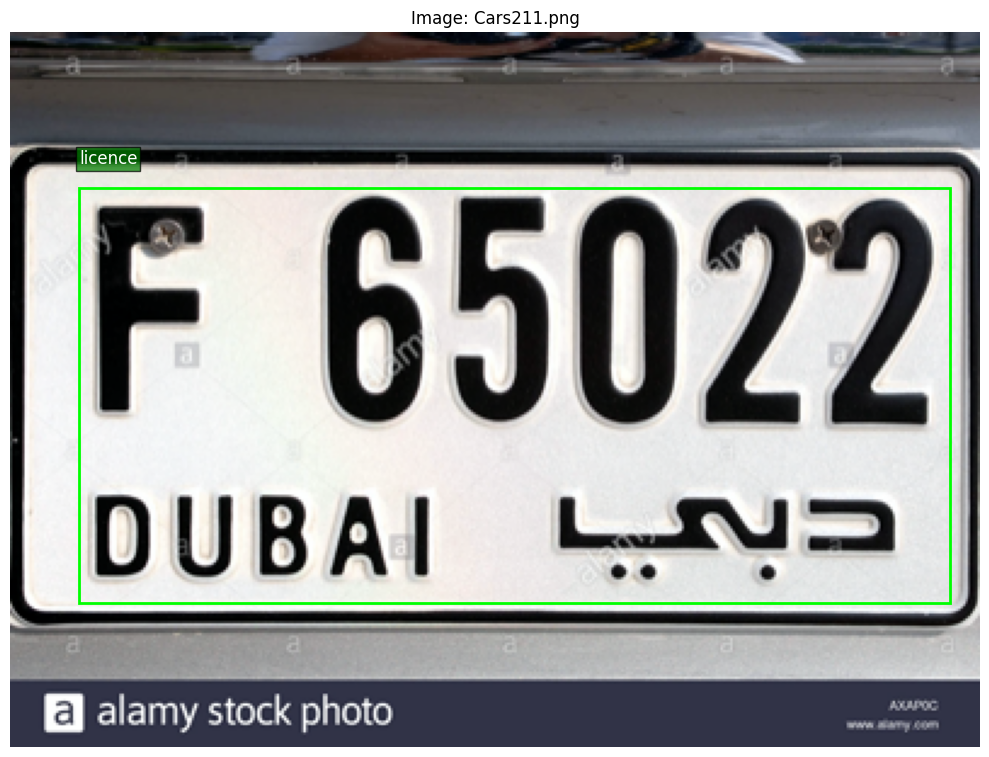


Boxes Near Image Edges:
Visualizing Cars370 (problematic: Boxes Near Image Edges)


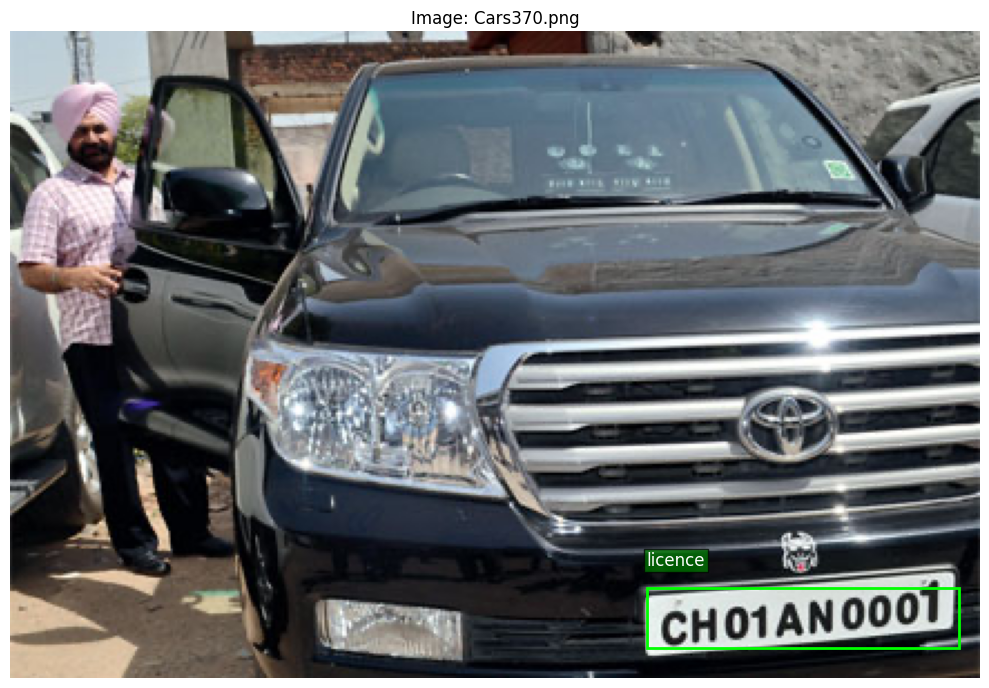

Visualizing Cars402 (problematic: Boxes Near Image Edges)


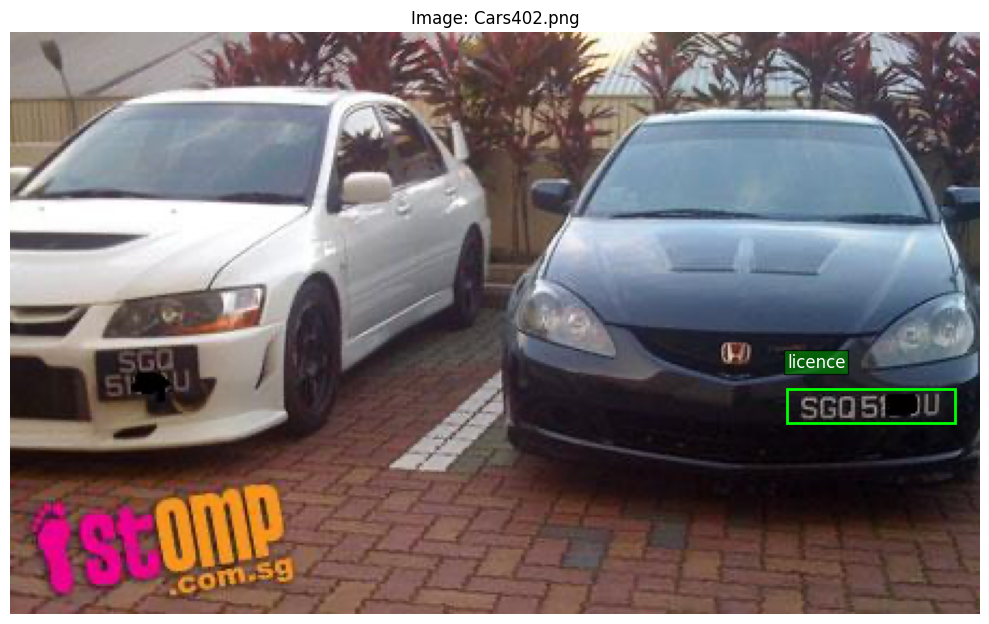

In [10]:
def visualize_problematic_cases(problematic_cases, annotations_df, images_dir, n_per_category=2):
    """
    Visualize examples of potentially problematic annotations
    
    Args:
        problematic_cases (dict): Dictionary of DataFrames with problematic cases
        annotations_df (DataFrame): Full annotations DataFrame
        images_dir (str): Directory containing image files
        n_per_category (int): Number of examples to show per category
    """
    if not problematic_cases:
        print("No problematic cases to visualize")
        return
    
    # Categories to check
    categories = [
        ('small_boxes', 'Unusually Small Boxes'),
        ('large_boxes', 'Unusually Large Boxes'),
        ('extreme_aspect_ratio', 'Extreme Aspect Ratios'),
        ('edge_boxes', 'Boxes Near Image Edges')
    ]
    
    for category_key, category_name in categories:
        df = problematic_cases.get(category_key)
        if df is not None and len(df) > 0:
            print(f"\n{category_name}:")
            
            # Get unique filenames and sample
            unique_files = df['file'].unique()
            sample_files = random.sample(list(unique_files), min(n_per_category, len(unique_files)))
            
            for file in sample_files:
                print(f"Visualizing {file} (problematic: {category_name})")
                visualize_image_with_boxes(file, annotations_df, images_dir)

# Visualize problematic cases
if annotations_df is not None and 'problematic_cases' in locals():
    visualize_problematic_cases(problematic_cases, annotations_df, images_dir)

## 9. Interactive Visualization Tool

This function allows you to examine specific images by providing their basename.

In [11]:
def visualize_specific_image(annotations_df, images_dir):
    """
    Visualize a specific image by providing its basename
    
    Args:
        annotations_df (DataFrame): DataFrame containing annotations
        images_dir (str): Directory containing image files
    """
    # Print instructions
    print("To visualize a specific image, run:")
    print("image_basename = 'CAR0'  # replace with your desired image name")
    print("visualize_image_with_boxes(image_basename, annotations_df, images_dir)")

# Call the function to display instructions
visualize_specific_image(annotations_df, images_dir)

To visualize a specific image, run:
image_basename = 'CAR0'  # replace with your desired image name
visualize_image_with_boxes(image_basename, annotations_df, images_dir)


## 10. Summary

In this notebook, we:

1. Loaded the license plate detection dataset from DataV2
2. Parsed the XML annotation files
3. Checked for matches between images and annotations
4. Visualized random images with their bounding boxes
5. Performed quality checks on the annotations
6. Visualized potentially problematic annotations

Based on the visualizations, you can determine if the license plates are correctly annotated in this dataset. Look for:
- Whether the bounding boxes correctly align with the license plates
- If annotations are missing or incorrect
- Whether there are any systematic issues with the annotations

This analysis helps ensure the dataset quality before using it for model training.